LOL Player Radar Chart Search System
✅ Successfully loaded 81 player records
Enter player name to search, type 'quit' to exit.
Sample player names: 369, aiming, alvaro, apa, azhi



Enter player name (type 'quit' to exit):  chovy


Found player: chovy (Mid)


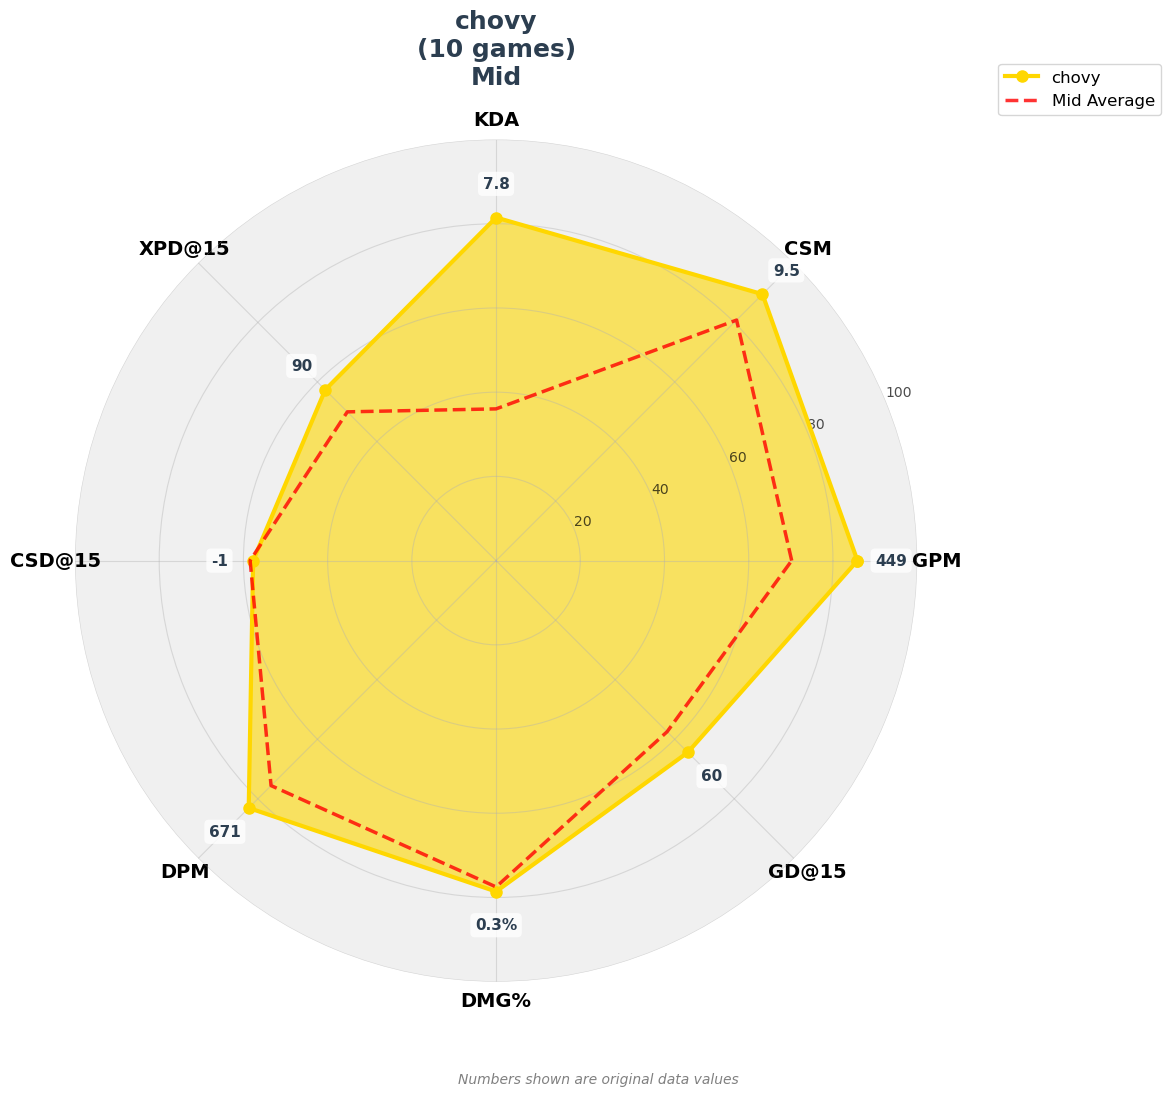

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import warnings
warnings.filterwarnings('ignore')

# Set matplotlib to display inline in Jupyter
%matplotlib inline

def load_data():
    
    try:
        df = pd.read_csv('player_statistics_cleaned_final.csv') # load csv file
        
        # I choose the eight most important numeric values to make Radar Chart
        numeric_cols = ['GoldPerMin', 'CSPerMin', 'KDA', 'XPD@15', 'CSD@15', 'DPM', 'DamagePercent', 'GD@15']
        for col in numeric_cols:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce') #to prevent invalid data
        
        # Fill missing values
        df = df.fillna(0)
        
        print(f"✅ Successfully loaded {len(df)} player records")
        
        return df
        
    except FileNotFoundError:
        print("❌ File 'player_statistics_cleaned_final.csv' not found")
        return None
    except Exception as e:
        print(f"❌ Data loading error: {e}")
        return None

def normalize_data(df, metrics):
    """Normalize data to 0-100 range"""
    normalized = df.copy()
    
    for metric in metrics:
        if metric in df.columns:
            values = df[metric]
            max_val = values.max()
            min_val = values.min()
            
            if max_val != min_val:
                normalized[metric] = ((values - min_val) / (max_val - min_val)) * 100
            else:
                normalized[metric] = 50
    
    return normalized

def create_octagon_radar(player_data_normalized, player_data_original, position_avg_data, player_name, position):
    """Create octagon radar chart with original data values displayed"""
    
    
    metrics = ['GoldPerMin', 'CSPerMin', 'KDA', 'XPD@15', 'CSD@15', 'DPM', 'DamagePercent', 'GD@15']
    labels = ['GPM', 'CSM', 'KDA', 'XPD@15', 'CSD@15', 'DPM', 'DMG%', 'GD@15']
    
    
    player_values = []
    avg_values = []
    
    
    original_values = []
    
    for metric in metrics:
        if metric in player_data_normalized.columns:
            # Normalized values for radar chart shape
            player_values.append(player_data_normalized[metric].iloc[0])
            avg_values.append(position_avg_data[metric])
            
            # Original values for display
            original_values.append(player_data_original[metric].iloc[0])
        else:
            # fill zero
            player_values.append(0)
            avg_values.append(0)
            original_values.append(0)
    
    # Calculate octagon angles
    N = 8
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Complete the circle
    
    player_values += player_values[:1]  # Complete the circle
    avg_values += avg_values[:1]  # Complete the circle
    original_values += original_values[:1]  # Complete the circle
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(projection='polar'))
    fig.patch.set_facecolor('white')
    
    # Set background to gray
    ax.set_facecolor('#f0f0f0')
    
    # Draw player data (yellow filled area)
    ax.plot(angles, player_values, 'o-', linewidth=3, 
            label=f'{player_name}', color='#FFD700', markersize=8)
    ax.fill(angles, player_values, alpha=0.6, color='#FFD700')
    
    # Draw position average data (red dashed line)
    ax.plot(angles, avg_values, '--', linewidth=2.5, 
            label=f'{position} Average', color='red', alpha=0.8)
    
    # Add original data values as text labels
    for i, (angle, normalized_val, original_val, label) in enumerate(zip(angles[:-1], player_values[:-1], original_values[:-1], labels)):
        # Calculate text position (slightly outside the data point)
        text_radius = normalized_val + 8  # Add offset from the data point
        
        # Format the original value based on the metric type
        if label in ['GPM', 'DPM', 'XPD@15', 'CSD@15', 'GD@15']:
            # Integer values
            text_value = f"{int(original_val)}"
        elif label == 'DMG%':
            # Percentage with 1 decimal
            text_value = f"{original_val:.1f}%"
        else:
            # Float values with 1-2 decimals
            text_value = f"{original_val:.1f}"
        
        # Add text annotation
        ax.text(angle, text_radius, text_value, 
                ha='center', va='center', 
                fontsize=11, fontweight='bold', 
                color='#2c3e50',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='none'))
    
    # Set labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=14, fontweight='bold')
    
    # Set radial axis
    ax.set_ylim(0, 100)
    ax.set_yticks([20, 40, 60, 80, 100])
    ax.set_yticklabels(['20', '40', '60', '80', '100'], fontsize=10, alpha=0.7)
    ax.grid(True, alpha=0.4)
    
    # Set title
    games = player_data_original['Games'].iloc[0] if 'Games' in player_data_original.columns else 'N/A'
    ax.set_title(f'{player_name}\n({games} games)\n{position}', 
                size=18, fontweight='bold', pad=40, color='#2c3e50')
    
    # Beautify chart
    ax.spines['polar'].set_visible(False)
    
    # Add legend
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=12)
    
    # Add note about the values
    fig.text(0.5, 0.02, 'Numbers shown are original data values', 
             ha='center', va='bottom', fontsize=10, style='italic', color='gray')
    
    plt.tight_layout()
    plt.show()

def search_player(df):
    """Search player and display radar chart"""
    
    # Eight metrics for normalization
    metrics = ['GoldPerMin', 'CSPerMin', 'KDA', 'XPD@15', 'CSD@15', 'DPM', 'DamagePercent', 'GD@15']
    
    # Normalize all data
    normalized_df = normalize_data(df, metrics)
    
    # Calculate average data for each position
    position_averages = {}
    for position in df['Position'].unique():
        if pd.notna(position): #pd.notna : check is not NaN or not.
            position_data = normalized_df[normalized_df['Position'] == position] # only save data that return True
            
            avg_data = {}
            for metric in metrics:
                if metric in position_data.columns:
                    avg_data[metric] = position_data[metric].mean()
                else:
                    avg_data[metric] = 0
            position_averages[position] = avg_data
    
    while True:
        
        player_input = input("\nEnter player name (type 'quit' to exit): ").strip() #strip() clean the leading space 
        
        # Check if user wants to quit
        if player_input.lower() == 'quit':
            print("Goodbye!")
            break
        
        if not player_input:
            print("Please enter a valid player name")
            continue
        
      
        player_found = df[df['PlayerName'].str.lower() == player_input.lower()] #return True if the player is searched 
        
        if player_found.empty:
            print(f"Player '{player_input}' not found")
            
            # Show possible similar player names
            similar_players = df[df['PlayerName'].str.lower().str.contains(player_input.lower(), na=False)] 
            if not similar_players.empty:
                print("You might be looking for:")
                for name in similar_players['PlayerName'].head(5):
                    print(f"   • {name}")
            continue
        
        # Get player information
        player_data = player_found.iloc[0]  #player_found is pd.dataframe type,  turn it into pd.Series type
        player_name = player_data['PlayerName']
        position = player_data['Position'] if pd.notna(player_data['Position']) else 'Unknown'#use the name to find his position
        
        print(f"Found player: {player_name} ({position})")
        
        # Using player's name to get normalized data from  "normalized_df"
        player_normalized = normalized_df[normalized_df['PlayerName'] == player_name]
        
        # Get original data for display
        player_original = df[df['PlayerName'] == player_name]
        
        # Get average data for this position
        if position in position_averages:
            avg_data = position_averages[position]
        else:
            # If position is unknown, use overall average
            avg_data = {}
            for metric in metrics:
                if metric in normalized_df.columns:
                    avg_data[metric] = normalized_df[metric].mean()
                else:
                    avg_data[metric] = 0
        
        
        try:
            create_octagon_radar(player_normalized, player_original, avg_data, player_name, position)
        except Exception as e: #error
            print(f"Error generating radar chart: {e}")

# ========================================
# Main Program Execution
# ========================================

print("LOL Player Radar Chart Search System")
print("=" * 40)

# Load data
df = load_data()


if df is not None:
    ###print(f"Number of searchable players: {len(df)}")
    print("Enter player name to search, type 'quit' to exit.")
    
    # Show some player names as reference
    print(f"Sample player names: {', '.join(df['PlayerName'].head(5).tolist())}")
    
    # Start searching
    search_player(df)
else:
    print("Unable to load data, please check if CSV file exists")

